<a href="https://colab.research.google.com/github/JNK234/PyTorch-Deep-Learning/blob/main/Neural%20Networks%20Implementation/CNN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
import torch
import torch.nn as nn
import torchvision.transforms as tfs
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm

In [4]:
# ALready Calculated
mean_gray = 0.1307
std_grey = 0.3081

stats = mean_gray, std_grey

In [5]:
transforms = tfs.Compose([
                          tfs.ToTensor(),
                          tfs.Normalize(*stats)
])

In [9]:
 train_dataset = MNIST(root='./Data', 
                       train=True, 
                       transform=transforms, 
                       download=True)
 
 valid_dataset = MNIST(root='./Data', 
                       train=False, 
                       transform=transforms, 
                       download=True)

In [28]:
def show_img(n):
  img, label = train_dataset[n]
  img = img.numpy() * std_grey + mean_gray
  plt.imshow(img.reshape((28,28)), cmap='gray')
  print("Label is ", label)

Label is  9


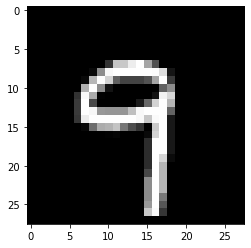

In [30]:
show_img(45343)

In [32]:
batch_size = 100

train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

valid_loader = DataLoader(valid_dataset, 
                          batch_size=batch_size)

In [34]:
len(train_dataset), len(valid_dataset)

(60000, 10000)

In [35]:
len(train_loader), len(valid_loader)

(600, 100)

Due to batch size of 100

In [79]:
class ImageClassificationBaseline(nn.Module):
  
  def training_step(self,batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self,batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = self.accuracy(out, labels)
    return {'val_loss':loss, 'val_acc':acc}

  def accuracy(self, outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / preds.numel())

  def validation_step_end(self, val_outputs, train_outputs):
    val_batch_losses = [x['val_loss'] for x in val_outputs]
    val_epoch_loss = torch.stack(val_batch_losses).mean()
    val_batch_acc = [x['val_acc'] for x in val_outputs]
    val_epoch_acc = torch.stack(val_batch_acc).mean()

    train_batch_losses = [x['val_loss'] for x in train_outputs]
    train_epoch_loss = torch.stack(train_batch_losses).mean()
    train_batch_acc = [x['val_acc'] for x in train_outputs]
    train_epoch_acc = torch.stack(train_batch_acc).mean()

    return {'train_loss':train_epoch_loss.item(), 'train_acc':train_epoch_acc.item(), 'val_loss':val_epoch_loss.item(), 'val_acc':val_epoch_acc.item()}

  def epoch_end(self, epoch, num_epochs, results):
    print("Epoch [{}/{}]: train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch+1, num_epochs, 
                                    results['train_loss'], results['train_acc'], results['val_loss'], results['val_acc']))

In [78]:
class CNNModel(ImageClassificationBaseline):

  def __init__(self):
    super(CNNModel, self).__init__()
    self.network = nn.Sequential(
        # inp_size: 1 x 28 x 28
        nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.MaxPool2d(2),

        # outp_size: 8 x 14 x 14
        nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding=2),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2),

        # outp_size: 32 x 7 x 7
        nn.Flatten(),
        # Flatten_size: 32 x 7 x 7 = 1568
        nn.Linear(1568, 600),
        nn.Dropout(0.5),
        nn.Linear(600, 10)
    )

  def forward(self, xb):
      return self.network(xb)

In [77]:
def get_default_device():
  """Pick GPU if availabel, else CPU"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  """ Wrap a dataloader to move data into device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """ Yeild a batch of data after moving it to device"""
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    """ Number of batches"""
    return len(self.dl)

In [76]:
@torch.no_grad()
def evaluate(model, val_loader, train_loader):
    model.eval()
    val_outputs = [model.validation_step(batch) for batch in val_loader]
    train_outputs = [model.validation_step(batch) for batch in train_loader]
    return model.validation_step_end(val_outputs, train_outputs)

def fit(epochs, lr, model, train_dl, valid_dl, opt_func = torch.optim.SGD):
    
    torch.cuda.empty_cache()
    history = []
    
    # Set up optimizer 
    optimizer = opt_func(model.parameters(), lr)
    # set-up one cycle learning rate scheduler
    # schd = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, steps_per_epoch=len(train_dl), epochs=epochs)
    
    for epoch in range(epochs):
        
        model.train()
        # Training phase
        for batch in tqdm(train_dl):
            loss = model.training_step(batch)
            loss.backward()            
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation Phase
        results = evaluate(model, valid_dl, train_dl)
        model.epoch_end(epoch, epochs, results)
        history.append(results)
    
    return history
        
        

In [53]:
device = get_default_device()
device

device(type='cuda')

In [67]:
model = CNNModel()
model = model.to(device)

train_loader = DeviceDataLoader(train_loader, device)
valid_loader = DeviceDataLoader(valid_loader, device)

In [58]:
opt_func = torch.optim.Adam
lr = 0.001
num_epochs = 10

In [70]:
history = fit(epochs = num_epochs, 
              lr = lr, 
              model = model, 
              train_dl = train_loader, 
              valid_dl = valid_loader, 
              opt_func = opt_func)

Epoch [0/10]: train_loss: 0.0612, train_acc: 0.9813, val_loss: 0.0573, val_acc: 0.9837
Epoch [1/10]: train_loss: 0.0543, train_acc: 0.9823, val_loss: 0.0585, val_acc: 0.9820
Epoch [2/10]: train_loss: 0.0354, train_acc: 0.9889, val_loss: 0.0375, val_acc: 0.9880
Epoch [3/10]: train_loss: 0.0263, train_acc: 0.9915, val_loss: 0.0349, val_acc: 0.9888
Epoch [4/10]: train_loss: 0.0164, train_acc: 0.9951, val_loss: 0.0256, val_acc: 0.9911
Epoch [5/10]: train_loss: 0.0178, train_acc: 0.9943, val_loss: 0.0384, val_acc: 0.9875
Epoch [6/10]: train_loss: 0.0170, train_acc: 0.9941, val_loss: 0.0368, val_acc: 0.9889
Epoch [7/10]: train_loss: 0.0120, train_acc: 0.9963, val_loss: 0.0262, val_acc: 0.9917
Epoch [8/10]: train_loss: 0.0123, train_acc: 0.9958, val_loss: 0.0355, val_acc: 0.9888
Epoch [9/10]: train_loss: 0.0161, train_acc: 0.9944, val_loss: 0.0414, val_acc: 0.9886


In [75]:
history1 = fit(epochs = 3, 
              lr = lr, 
              model = model, 
              train_dl = train_loader, 
              valid_dl = valid_loader, 
              opt_func = opt_func)


Epoch [0/3]: train_loss: 0.0107, train_acc: 0.9965, val_loss: 0.0380, val_acc: 0.9890



Epoch [1/3]: train_loss: 0.0088, train_acc: 0.9969, val_loss: 0.0361, val_acc: 0.9909



Epoch [2/3]: train_loss: 0.0083, train_acc: 0.9973, val_loss: 0.0403, val_acc: 0.9894
